### Bibliotecas

*   A biblioteca [`requests`](https://pypi.org/project/requests/) do Python é usada para fazer requisições HTTP, permitindo conectar a servidores web, enviar dados e receber respostas;
*   A biblioteca [`pytz`](https://pypi.org/project/pytz/) do Python é usada para trabalhar com fusos horários, permitindo manipulação de datas e horas em diferentes regiões do mundo
*   A biblioteca [`BeautifulSoup`](https://pypi.org/project/beautifulsoup4) do Python é usada para extrair dados de documentos HTML/XML, permitindo navegar, pesquisar e modificar o conteúdo do documento, sendo amplamente utilizada para web scraping.

In [34]:
# @title
import random
import os
import requests
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from enum import Enum
from bs4 import BeautifulSoup
from datetime import datetime

### Funções utilitárias

Essas funções serão utilizadas em diferentes partes do notebook.

In [35]:
# @title
agents = ["Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36", "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:109.0) Gecko/20100101 Firefox/116.0", "Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36", "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.6 Safari/605.1.15", "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36 Edg/115.0.1901.188", "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36 Edg/117.0.0.0", "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36"]

def get_agent():
    number_of_agents = len(agents) - 1
    agent_index = random.randint(0, number_of_agents)
    return agents[agent_index]

class Sources(str, Enum):
    B3 = 'b3' # Bolsa Brasileira (Brasil)
    CEPEA = 'cepea' # Cpea/Esalq para SP e interior
    COOPAMA = 'coopama' # Coopama, Machado MG
    COOPERCAM = 'coopercam' # Coopercam, Campos Gerais MG
    CCMG = 'ccmg' # Centro do Comércio de Café, Varginha MG
    COOXUPE = 'cooxupe' # Cooxupé, Guaxupé MG
    CAFEPOCOS = 'cafe-pocos' # Café Poços, Poços de Caldas MG
    COOABRIEL = 'cooabriel'

    def __str__(self) -> str:
        return self.value

def date_time(separator_date='/', separator_time=':'):
   snap = datetime.now(pytz.timezone('America/Sao_Paulo'))

   date = snap.strftime(f"%d{separator_date}%m{separator_date}%Y")
   time = snap.strftime(f"%H{separator_time}%M{separator_time}%S")

   date_time = {
      'date': date,
      'time': time
   }

   return date_time

def retain_numbers_in_string(str_value):
  result = ""
  digits = ",0123456789"
  for i in str_value:
      if i in digits:
          result += i

  return result

def comma_to_point(str_value):
  # Porque strings são imutáveis
  srt_as_list = list(str_value)

  for index, character in enumerate(srt_as_list):
      if (character == ','):
          srt_as_list[index] = '.'

  return ''.join(srt_as_list)


### Variáveis globais

Essas variáveis serão utilizadas em diferentes partes do notebook.

In [36]:
# @title
headers = {'User-Agent': get_agent()}
digits_for_floats = 2

### Cotações

Buscaremos cotações de preço de café em diferentes regioões/cidades do Brasil.

A idéia é consolidar essas cotações ao longo do tempo para fazer análises.

#### Cotação na B3

A Brasil, Bolsa, Balcão ([B3](https://www.b3.com.br)) é a bolsa de valores brasileira, que fica sediada na cidade de São Paulo.

In [37]:
import re
import requests
from bs4 import BeautifulSoup

headers = {
    "User-Agent": "Mozilla/5.0"
}

def clean_float(value):
    value = re.sub(r'[^0-9.,]', '', value)
    return float(value.replace(',', '.'))

def price_b3_via_cooxupe(url):
    site = requests.get(url, headers=headers, timeout=10)
    soup = BeautifulSoup(site.content, 'html.parser')

    tbody = soup.find('tbody')

    us_coffe = None
    us_dolar = None

    for row in tbody.find_all('tr'):
        columns = row.find_all('td')
        if not columns:
            continue

        desc = columns[0].text.strip()
        value = columns[1].text.strip()

        # primer contrato de café (front month)
        if us_coffe is None and 'Cafe' in desc and 'B3' not in desc:
            us_coffe = clean_float(value)

        # dólar
        if 'DOL COM' in desc:
            us_dolar = clean_float(value)

    if us_coffe is None or us_dolar is None:
        return None

    return round(us_coffe * us_dolar, 2)

    price = price_b3_via_cooxupe("https://hubdocafe.cooxupe.com.br/industria/")
print(price)



0


#### Cotação do CPEA

O [CEPEA](https://www.cepea.esalq.usp.br/br) é o Centro de Estudos Avançados em Economia Aplicada da Escola Superior de Agricultura (Esalq/USP).

In [56]:
def price_cpea(headers, url):
  br_price = 0

  try:
    site = requests.get(url, headers=headers)
    soup = BeautifulSoup(site.content, 'html.parser')

    table = soup.find('table', {'id':'imagenet-indicador1'})
    tbody = table.find('tbody')

    for row in tbody.find_all('tr'):
      columns = row.find_all('td')

      if columns != []:

        price = columns[1].text.strip()
        price = retain_numbers_in_string(price)
        price = comma_to_point(price)
        br_price = float(price)

        break

    if br_price == 0:
      display('Erro na leitura de dados do CPEA')
    return round(br_price, digits_for_floats)

  except Exception as erro:
    display(erro)
    return 0

price = price_cpea(headers, "https://www.cepea.org.br/br/indicador/cafe.aspx")
display(price)

2180.2

#### Cotação da Coopama

A [Coopama](https://www.coopama.com.br/) é a Cooperativa Agrária de Machado que, entre outras atividades, oferece comercialização e armazenagem de café e outros grãos, como milho, soja, sorgo e aveia.

In [57]:
def price_coopama(headers, url):
  br_price = 0

  try:
    site = requests.get(url, headers=headers)
    soup = BeautifulSoup(site.content, 'html.parser')

    div_cotacao = soup.find('div', {'id':'cotacao-cafe'});
    spans = div_cotacao.find_all('span', {'class':'col'})

    found = False

    for span in spans:
      if (found):
        price = retain_numbers_in_string(span.text[:8])
        br_price = float(price)
        break
      if "Duro tipo 6" in span.text:
        found = True

    if br_price == 0:
      display('Erro na leitura de dados da Coopama')
      return br_price

    return round(br_price, digits_for_floats)

    #Raspar coopama
  except Exception as erro:
    display(erro)
    return 0

price = price_coopama(headers, "https://www.coopama.com.br/")
display(price)

2110.0

#### Cotação da Coopercam

A [Coopercam](https://coopercam.com.br/) é a Cooperativa do Cafeicultores de Campos Gerais MG e Campo do Meio MG. Sediado no segundo maior município produtor de café do Brasil, a cooperativa atua em aproximadamente 15 mil ha de café, que abrange os munícipios de Campos Gerais, Campo do Meio, distrito de Córrego do Ouro e cidades circunvizinhas.

In [58]:
def price_coopercam(headers, url):
    br_price = 0
    # URL de la cotización de Coopercam
    url = "https://coopercam.com.br/cotacoes/"

    try:
        site = requests.get(url, headers=headers)
        soup = BeautifulSoup(site.content, 'html.parser')

        # 1. Encontrar el primer 'steps-container', que contiene la cotización más reciente
        latest_cotacao_div = soup.find('div', {'class': 'steps-container'})

        if not latest_cotacao_div:
            # Si no se encuentra el contenedor principal, muestra un error y sale
            print('Erro: Não foi possível encontrar o bloco de cotações mais recente (steps-container).')
            return 0

        # 2. Buscar el contenedor <nav> dentro del bloque más reciente
        nav_prices = latest_cotacao_div.find('nav', {'class': 'd-grid'})

        # 3. Buscar todos los enlaces <a> dentro de <nav>
        price_links = nav_prices.find_all('a')

        # 4. Iterar sobre los enlaces para encontrar el precio de "Duro Limpo"
        for link in price_links:
            if "Duro Limpo" in link.text:
                # El valor está dentro de la etiqueta <b> dentro del enlace <a>
                price_b_tag = link.find('b')

                if price_b_tag:
                    price = price_b_tag.text.strip()

                    # Limpieza y Conversión: "R$ 2.285,00" -> "2285,00" -> "2285.00"
                    # Eliminamos el "R$" y los espacios
                    price = price.replace('R$', '').strip()
                    price = retain_numbers_in_string(price)
                    price = comma_to_point(price)
                    br_price = float(price)
                    break

        if br_price == 0:
            print('Erro: Não foi possível encontrar a cotação "Duro Limpo" na Coopercam.')

        return round(br_price, digits_for_floats)

    except Exception as erro:
        print(f"Erro na Coopercam: {erro}")
        return 0

price = price_coopercam(headers, "https://coopercam.com.br/cotacoes")
display(price)

2175.0

#### Cotação do CCMG

O [CCMG](https://cccmg.com.br/) é o Centro do Comércio de Café do Estado de Minas Gerais, uma instituição representativa, sem fins lucrativos, que agrega empresas que atuam no agronegócio café.

In [41]:

def price_ccmg(headers, url):
    """
    Lê a cotação principal do CCCMG (B/C tipo 6, bebida dura)
    diretamente da página de cotação do CCCMG.
    """
    br_price = 0

    try:
        site = requests.get(url, headers=headers)
        soup = BeautifulSoup(site.content, 'html.parser')

        # Procura a tabela de preços principal (jet-dynamic-table)
        table = soup.find('table', {'class': 'jet-dynamic-table'})
        if not table:
            print("Erro: tabela principal do CCCMG não encontrada.")
            return 0

        tbody = table.find('tbody')
        rows = tbody.find_all('tr')

        # Primeira linha = tipo 6 bebida dura
        first_row = rows[0]
        columns = first_row.find_all('td')

        price_raw = columns[1].text.strip()  # ex: "R$ 2.232,00"

        # Limpeza correta
        price_raw = price_raw.replace("R$", "").strip()
        price_raw = price_raw.replace(" ", "")

        # Remove apenas pontuação de milhares (ponto)
        price_raw = price_raw.replace(".", "")

        # Troca vírgula por ponto
        price_raw = price_raw.replace(",", ".")

        # Converte agora para float
        br_price = float(price_raw)

        # Mantém formato padrão
        return round(br_price, 2)

    except Exception as erro:
        print(f"Erro no scraper do CCCMG: {erro}")
        return 0


# Teste
price = price_ccmg(headers, "https://cccmg.com.br/cotacao-do-cafe/13-11-2025/")
print("Preço CCCMG:", f"{price:.2f}")





Preço CCCMG: 2232.00


#### Cotação da Cooxupé

A [Cooxupé](https://www.cooxupe.com.br/) é a Cooperativa Regional de Cafeicultores em Guaxupé MG. Atualmente, é a maior cooperativa de cafeicultores do mundo, contando com mais de 20 mil cooperados espalhados em mais de 330 municípios localizados no Sul de Minas, Cerrado Mineiro, Matas de Minas e Vale do Rio Pardo (no estado de São Paulo).

Ler cotações no [Hub do Café](https://hubdocafe.cooxupe.com.br/cafe-da-tarde/).

In [59]:
import requests
from bs4 import BeautifulSoup

def price_cooxupe(headers, url="https://hubdocafe.cooxupe.com.br/cafe-da-tarde/"):
    """
    Extrae el precio “Até R$ …” para Café fino Cooxupé desde la página 'Café da Tarde'.
    Devuelve un float con 2 decimales.
    """
    try:
        resp = requests.get(url, headers=headers)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.content, "html.parser")

        # Buscar todos los <li> con clase text-cafefino-cards
        li_cards = soup.find_all("li", class_="text-cafefino-cards")
        if not li_cards:
            print("Erro: não encontrou elementos de cotação de Cooxupé (‘Até R$ …’).")
            return 0.0

        # Asumimos que el primero corresponde a la cotación más reciente
        preco_raw = li_cards[0].get_text(strip=True)  # por ejemplo: "Até R$2.333,00"

        # Limpiar la parte “Até ”
        # Puede comenzar con "Até R$" o "AtéR$" según cómo esté codificado
        preco_raw = preco_raw.replace("Até", "").replace("até", "").strip()

        # Ahora debe ser algo tipo "R$2.333,00" o "R$ 2.333,00"
        preco_raw = preco_raw.replace("R$", "").replace(" ", "")

        # Cambiar formato brasileño: puntos de miles / coma decimal
        preco_raw = preco_raw.replace(".", "").replace(",", ".")

        # Convertir a float
        value = float(preco_raw)

        return round(value, 2)

    except Exception as e:
        print(f"Erro no scraper Cooxupé (Café da Tarde): {e}")
        return 0.0


# Test
price = price_cooxupe(headers)
print("Preço Cooxupé (fino):", f"{price:.2f}")


Preço Cooxupé (fino): 2223.00


#### Cotação da Café Poços

A [Café Poços]() é a Cooperativa Regional dos Cafeicultores de Poços de Caldas.

Ler cotações no [notícias agrícolas](https://www.noticiasagricolas.com.br/cotacoes/cafe/cafe-arabica-mercado-fisico-tipo-6-7).

In [60]:
def price_cafe_pocos(headers, url="https://www.noticiasagricolas.com.br/cotacoes/cafe/cafe-arabica-mercado-fisico-tipo-6-7"):
    """
    Extrae la cotação más recente de 'Poços de Caldas/MG (Café Poços)'
    del portal Notícias Agrícolas.
    Retorna el precio como float con 2 decimales.
    """
    try:
        resp = requests.get(url, headers=headers)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.content, "html.parser")

        cotacoes = soup.find_all("div", class_="cotacao")
        if not cotacoes:
            print("Erro: não encontrou blocos de cotação.")
            return 0.0

        tabela = cotacoes[0].find("table")
        if not tabela:
            print("Erro: tabela não encontrada no primeiro bloco.")
            return 0.0

        linhas = tabela.find_all("tr")

        preco = None

        for tr in linhas:
            cols = tr.find_all("td")
            if len(cols) < 2:
                continue

            municipio = cols[0].get_text(strip=True)
            valor_str = cols[1].get_text(strip=True)

            if "Poços de Caldas" in municipio or "Café Poços" in municipio:
                preco = valor_str
                break

        if not preco:
            print("Erro: não encontrou Poços de Caldas na cotação mais recente.")
            return 0.0

        if "s/" in preco.lower():
            return 0.0

        # CONVERSIÓN CORRECTA: "2.270,00" → "2270.00"
        preco = preco.replace(".", "").replace(",", ".")

        value = float(preco)

        return round(value, 2)

    except Exception as e:
        print(f"Erro no scraper Café Poços: {e}")
        return 0.0


# Test
p = price_cafe_pocos(headers)
print("Preço Café Poços:", f"{p:.2f}")




Preço Café Poços: 2180.00


#### Cotação da Cooabriel

In [74]:
import requests
from bs4 import BeautifulSoup
import json

headers = {
    "User-Agent": "Mozilla/5.0"
}

def price_cooabriel(headers, url="https://cooabriel.coop.br/cotacao-do-dia"):
    try:
        site = requests.get(url, headers=headers, timeout=10)
        soup = BeautifulSoup(site.text, "html.parser")

        next_data = soup.find("script", id="__NEXT_DATA__")
        data = json.loads(next_data.string)

        page_props = data["props"]["pageProps"]

        # 🔎 búsqueda genérica en todo el JSON
        def search_conilon(obj):
            if isinstance(obj, dict):
                if obj.get("nomeCafe") == "Conilon 7":
                    return obj
                for v in obj.values():
                    result = search_conilon(v)
                    if result:
                        return result

            elif isinstance(obj, list):
                for item in obj:
                    result = search_conilon(item)
                    if result:
                        return result
            return None

        cafe = search_conilon(page_props)

        if not cafe:
            print("Conilon 7 não encontrado")
            return 0.0

        last = cafe["cotacoes"][-1]
        return float(last["preco"])

    except Exception as e:
        print("Erro Cooabriel:", e)
        return 0.0


print(price)




1250.0


Erro Cooabriel: 'semanal'
0.0


### Leitura dos Dados

In [75]:
# ---- CONFIGURAR QUAIS FONTS DESEJA LER ----
b3 = True
cpea = True
coopama = True
coopercam = True
ccmg = True
cooxupe = True
cafepocos = True
cooabriel = True

# ---- INICIAR DICIONÁRIO COM TODAS AS FONTES ----
prices_df = {
    "data": [],
    Sources.B3: [],
    Sources.CEPEA: [],
    Sources.COOPAMA: [],
    Sources.COOPERCAM: [],
    Sources.CCMG: [],
    Sources.COOXUPE: [],
    Sources.CAFEPOCOS: [],
    Sources.COOABRIEL: [],

}

# ---- REGISTRAR A DATA ATUAL ----
date = date_time()['date']
prices_df["data"].append(date)

print("📊 Lendo dados das fontes...")


# =============================
#   LEITURAS DAS COTAÇÕES
# =============================

# ---- B3 ----
if b3:
    try:
        value = price_b3_via_cooxupe(headers, "https://hubdocafe.cooxupe.com.br/industria/")
        prices_df[Sources.B3].append(value)
    except:
        prices_df[Sources.B3].append(None)
else:
    prices_df[Sources.B3].append(None)


# ---- CEPEA ----
if cpea:
    try:
        value = price_cpea(headers, "https://www.cepea.org.br/br/indicador/cafe.aspx")
        prices_df[Sources.CEPEA].append(value)
    except:
        prices_df[Sources.CEPEA].append(None)
else:
    prices_df[Sources.CEPEA].append(None)


# ---- COOPAMA ----
if coopama:
    try:
        value = price_coopama(headers, "https://www.coopama.com.br/")
        prices_df[Sources.COOPAMA].append(value)
    except:
        prices_df[Sources.COOPAMA].append(None)
else:
    prices_df[Sources.COOPAMA].append(None)


# ---- COOPERCAM ----
if coopercam:
    try:
        value = price_coopercam(headers, "https://coopercam.com.br/cotacoes/")
        prices_df[Sources.COOPERCAM].append(value)
    except:
        prices_df[Sources.COOPERCAM].append(None)
else:
    prices_df[Sources.COOPERCAM].append(None)


# ---- CCMG ----
if ccmg:
    try:

        value = price_ccmg(headers, "https://cccmg.com.br/cotacao-do-cafe/13-11-2025/")
        prices_df[Sources.CCMG].append(value)
    except:
        prices_df[Sources.CCMG].append(None)
else:
    prices_df[Sources.CCMG].append(None)


# ---- COOXUPÉ ----
if cooxupe:
    try:
        value = price_cooxupe(headers)
        prices_df[Sources.COOXUPE].append(value)
    except:
        prices_df[Sources.COOXUPE].append(None)
else:
    prices_df[Sources.COOXUPE].append(None)


# ---- CAFÉ POÇOS ----
if cafepocos:
    try:
        value = price_cafe_pocos(headers)
        prices_df[Sources.CAFEPOCOS].append(value)
    except:
        prices_df[Sources.CAFEPOCOS].append(None)
else:
    prices_df[Sources.CAFEPOCOS].append(None)

  # ---- COOABRIEL ----
if cooabriel:
    try:
        value = price_cooabriel(headers)
        prices_df[Sources.COOABRIEL].append(value)
    except:
        prices_df[Sources.COOABRIEL].append(None)
else:
    prices_df[Sources.COOABRIEL].append(None)









📊 Lendo dados das fontes...


### Salvamento dos Dados

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
df = pd.DataFrame(prices_df)

file_name = '/content/drive/MyDrive/precos_cafe.csv'
if os.path.isfile(file_name):
  df.to_csv(file_name, mode='a', header=False, index=False)
  display('Dados salvos no final do arquivo')
else:
  df.to_csv(file_name, index=False)
  display('Arquivo criado')
display(df)

'Dados salvos no final do arquivo'

,data,b3,cepea,coopama,coopercam,ccmg,cooxupe,cafe-pocos,cooabriel
0,17/01/2026,None,2180.2,2110.0,2175.0,2232.0,2223.0,2180.0,1250.0


### Visualização dos Dados

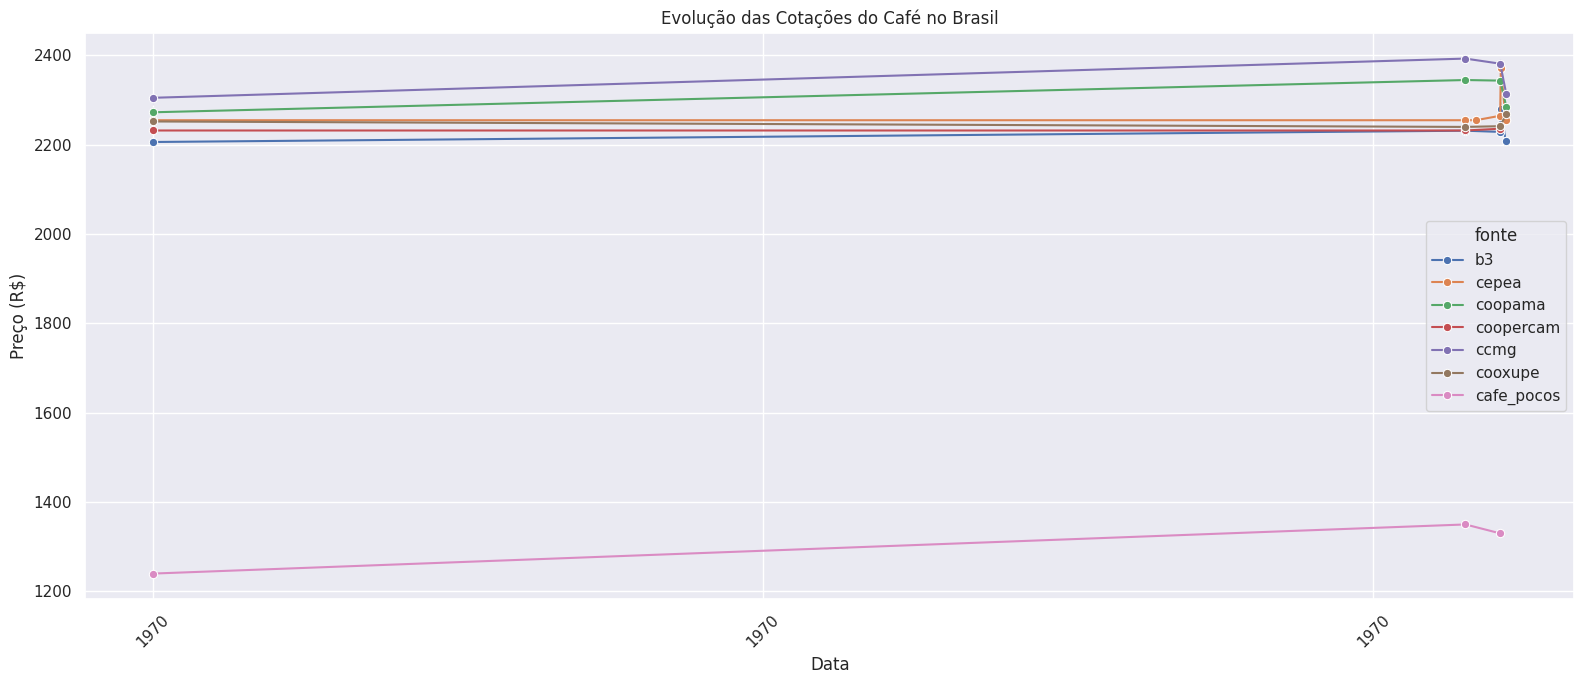

,data,fonte,price
167,NaT,cooxupe,2180.0
187,1970-01-01 00:00:00.000002208,cafe_pocos,1330.0
191,1970-01-01 00:00:00.000002151,cafe_pocos,1350.0
192,1970-01-01 00:00:00.000000000,cafe_pocos,1240.0
195,NaT,cafe_pocos,1250.0


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_name = '/content/drive/MyDrive/precos_cafe.csv'

# -------------------------------
# 1. Definir nombres reales
# -------------------------------
column_names = [
    "index",
    "data",
    "b3",
    "cepea",
    "coopama",
    "coopercam",
    "ccmg",
    "cooxupe",
    "cafe_pocos"
]

# -------------------------------
# 2. Leer CSV
# -------------------------------
df = pd.read_csv(
    file_name,
    header=None,
    names=column_names,
    sep=",",
    engine="python"
)

# Eliminar la columna "index" que no hace falta
df = df.drop(columns=["index"])

# -------------------------------
# 3. Convertir fecha
# -------------------------------
df["data"] = pd.to_datetime(df["data"], dayfirst=True, errors="coerce")

# -------------------------------
# 4. Transformar wide → long
# -------------------------------
df_lf = df.melt(
    id_vars="data",
    var_name="fonte",
    value_name="price"
)

# Eliminar valores vacíos o ceros (CCMG tiene 0 a veces)
df_lf = df_lf[df_lf["price"] > 0]

# -------------------------------
# 5. Gráfico
# -------------------------------
sns.set(font_scale=1)
plt.figure(figsize=(16, 7))

sns.lineplot(
    data=df_lf.groupby("fonte").tail(60),
    x="data",
    y="price",
    hue="fonte",
    marker="o"
)

plt.title("Evolução das Cotações do Café no Brasil")
plt.xlabel("Data")
plt.ylabel("Preço (R$)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# -------------------------------
# 6. Mostrar últimas filas en tabla
# -------------------------------
df_lf.tail()




#### Gráfico de Evolução de Preços

Gráfico de Linhas.

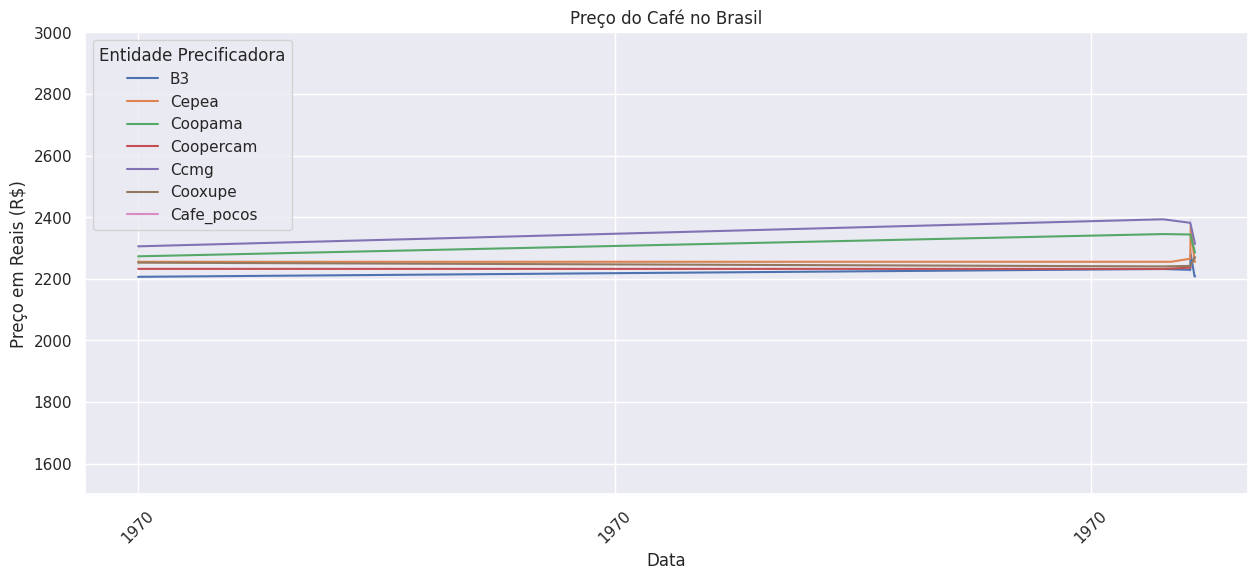

In [79]:
sns.set(font_scale=1)

plt.figure(figsize=(15, 6))

graph = sns.lineplot(x="data", y="price", data=df_lf.groupby("fonte").tail(30), hue="fonte", markers="o")
graph.set_title("Preço do Café no Brasil")
graph.set(xlabel="Data", ylabel="Preço em Reais (R$)")
graph.set_ylim(1500,3000)

legends, _ = graph.get_legend_handles_labels();
graph.legend(legends, list(map(lambda leg : leg.get_label().capitalize(), legends)), title="Entidade Precificadora")

plt.xticks(rotation=45)


plt.show()

#Grafico de barras

Gerando Gráfico de Comparação de Médias (Barras)...


/tmp/ipython-input-2728661349.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2728661349.py:38: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


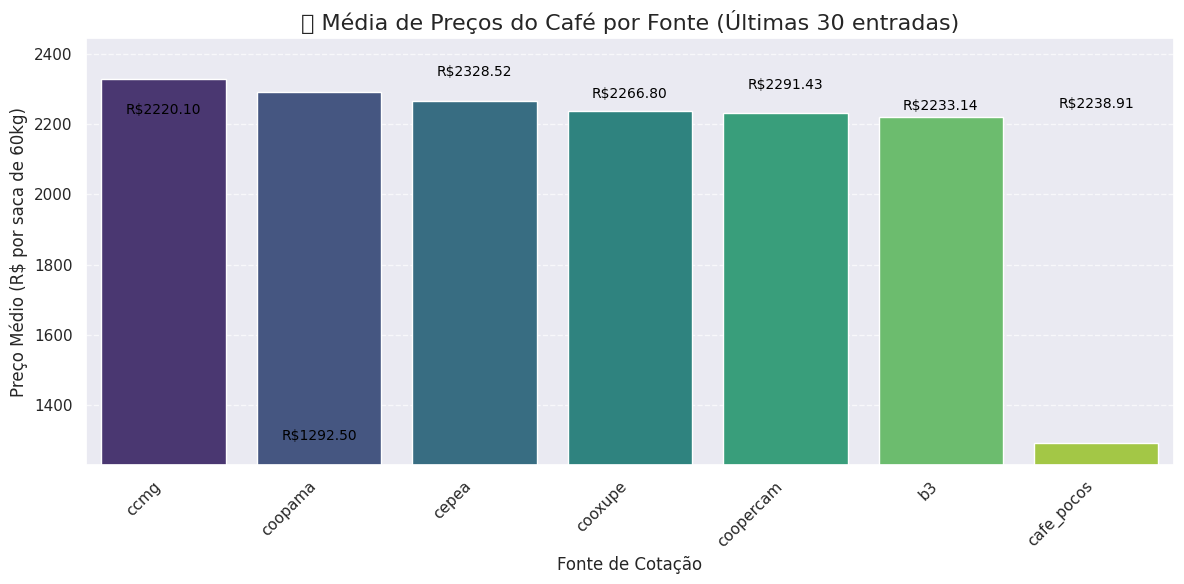

In [80]:
# ----------------------------------------
# 6. NOVO GRÁFICO: Média de Preços (Barras)
# ----------------------------------------
print("Gerando Gráfico de Comparação de Médias (Barras)...")

# Calcular a média de preço por fonte para as últimas 30 entradas
# O DataFrame 'df_lf' é o dataframe 'long format' criado na seção anterior
df_mean = df_lf.groupby("fonte").tail(30).groupby("fonte")["price"].mean().reset_index()
df_mean = df_mean.sort_values(by="price", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_mean,
    x="fonte",
    y="price",
    palette="viridis"
)

plt.title("💰 Média de Preços do Café por Fonte (Últimas 30 entradas)", fontsize=16)
plt.xlabel("Fonte de Cotação", fontsize=12)
plt.ylabel("Preço Médio (R$ por saca de 60kg)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(df_mean['price'].min() * 0.95, df_mean['price'].max() * 1.05) # Ajusta o limite Y

# Adiciona o valor no topo de cada barra
for index, row in df_mean.iterrows():
    plt.text(
        row.name, # Posição X (índice da barra)
        row.price, # Posição Y (valor do preço)
        f'R${row.price:.2f}',
        color='black',
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()

### Para Testes